In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

x = train.drop(columns=["Survived", "Cabin", "Ticket", "PassengerId"])
y = train["Survived"]

def new_features(x):
    x_copy = x.copy()
    x_copy["Title"] = x_copy["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    x_copy["Title"] = x_copy["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    x_copy['Title'] =x_copy['Title'].replace('Mlle', 'Miss')
    x_copy['Title'] = x_copy['Title'].replace('Ms', 'Miss')
    x_copy['Title'] = x_copy['Title'].replace('Mme', 'Mrs')
    x_copy["FamilySize"] = x_copy["Parch"]+ x_copy["SibSp"] + 1
    x_copy["IsAlone"] = (x_copy["FamilySize"] == 1).astype(int)
    x_copy["FarePerPerson"] = x_copy["Fare"]/x_copy["FamilySize"]
    return x_copy.drop(columns=["Name"])

Feature_Eng = FunctionTransformer(new_features)

num_col = ["Age", "FamilySize", "IsAlone", "FarePerPerson","Fare"]
cat_col = ["Title", "Embarked"]

num_feature = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="median")),
    ("Scaler", StandardScaler())
])
cat_feature = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessing = ColumnTransformer([
    ("num", num_feature, num_col),
    ("cat", cat_feature, cat_col)
])

Pipe = Pipeline(steps=[
    ("new_feature", Feature_Eng),
    ("preprocess", preprocessing),
    ("model", XGBClassifier(random_state=42,
                            eval_metric ="logloss",
                            ))
])


param_grid = {
    'model__n_estimators':[100, 400],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate':[0.01, 0.05, 0.1],
    'model__subsample': [0.8, .9],
    "model__colsample_bytree": [0.8, .9, 1.0],
}

grid = GridSearchCV(
    estimator= Pipe,
    param_grid= param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs= -1,
    verbose= 2
)

grid.fit(x, y)

print("Best Parameters:")
print(grid.best_params_)

print("\nBest CV ROC-AUC Score:")
print(grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 400, 'model__subsample': 0.8}

Best CV ROC-AUC Score:
0.8767253632787197


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

top_model = grid.best_estimator_
# 1. Get predictions on the training data
y_train_pred = top_model.predict(x)
train_acc = accuracy_score(y, y_train_pred)

# 2. Get the CV score (the score on 'unseen' folds during training)
cv_acc = grid.best_score_ 

print(f"Training Accuracy: {train_acc:.4%}")
print(f"Cross-Validation AUC: {cv_acc:.4%}")

Training Accuracy: 90.1235%
Cross-Validation AUC: 87.6725%


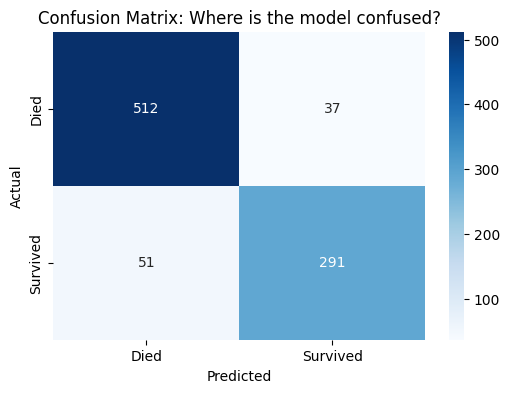

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       549
           1       0.89      0.85      0.87       342

    accuracy                           0.90       891
   macro avg       0.90      0.89      0.89       891
weighted avg       0.90      0.90      0.90       891



In [5]:
y_pred = grid.predict(x)

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Died', 'Survived'], 
            yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Where is the model confused?')
plt.show()

print(classification_report(y, y_pred))

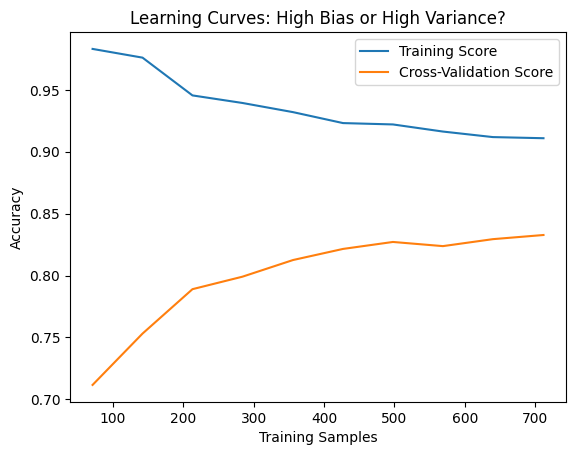

In [6]:


train_sizes, train_scores, test_scores = learning_curve(
    top_model, x, y, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.title('Learning Curves: High Bias or High Variance?')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

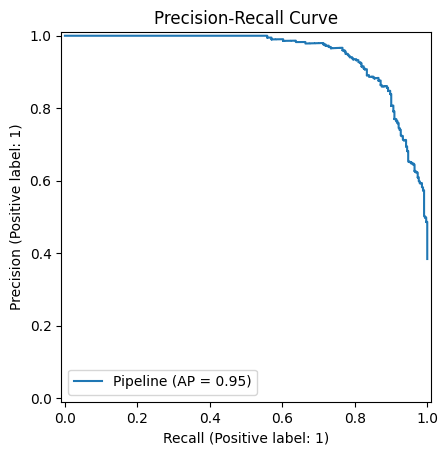

In [7]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(top_model, x, y)
plt.title("Precision-Recall Curve")
plt.show()

c:\Users\MBS TRADERS\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


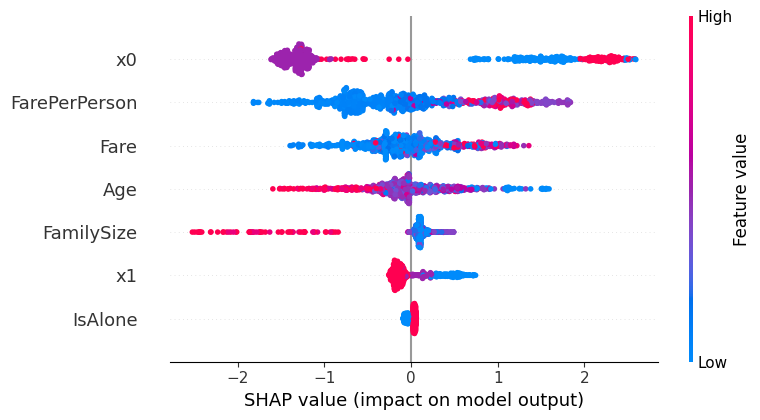

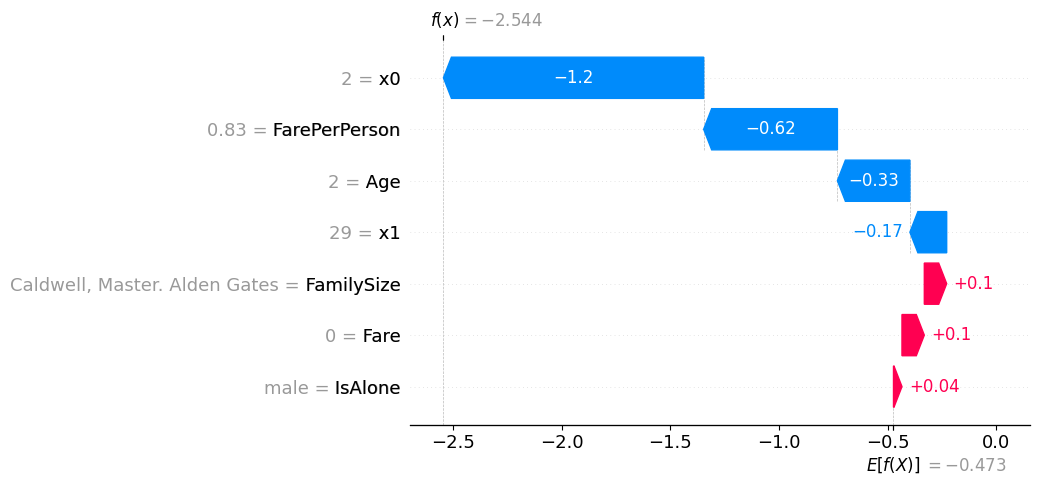

In [9]:
import shap
top_model = grid.best_estimator_

x_transformed = top_model.named_steps["preprocess"].transform(top_model.named_steps["new_feature"].transform(x))

cat_name = top_model.named_steps["preprocess"].named_transformers_["cat"]\
    .named_steps["encoder"].get_feature_names_out()

feature_names = num_col + list(cat_name)

explainer = shap.TreeExplainer(top_model.named_steps["model"])

shap_values = explainer.shap_values(x_transformed)

shap.summary_plot(shap_values, x_transformed, feature_names= feature_names)


shap.plots.waterfall(shap.Explanation(values= shap_values[77], base_values= explainer.expected_value, data= x.iloc[78], feature_names=feature_names))